In [6]:
# Let's import some basic libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

import yellowcab
from datetime import datetime

# From here on out we start preparing the data for PyTorch - let's first get the libraries we'll need
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.profiler import AdvancedProfiler as Profiler

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.preprocessing import RobustScaler
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow import keras
from tensorflow.keras import layers

from torch.nn import functional as F

pd.set_option('display.max_columns', None)

In [7]:
# And then import and view the data
print('Reading in the data')
df_orig = yellowcab.io.read_all_files('parquet')
print('Add weather data')
df_orig = yellowcab.io.utils.add_weather_data(df_orig)
print('filter 31.12.2020 -> Missing weather Data')
df_orig = df_orig[df_orig['tpep_pickup_datetime'] < datetime(2020, 12, 31)]
print('Sort values')
df_orig.sort_values('tpep_pickup_datetime')

Reading in the data
Add weather data
filter 31.12.2020 -> Missing weather Data
Sort values


,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,duration,start_month,start_day,start_hour,start_week,end_month,end_day,end_hour,end_week,weekend,weekday,start_location_long,start_location_lat,end_location_long,end_location_lat,PUBorough,PUZone,PUservice_zone,DOBorough,DOZone,DOservice_zone,Date time,Name,Maximum Temperature,Minimum Temperature,Temperature,Wind Chill,Heat Index,Precipitation,Snow,Snow Depth,Wind Speed,Wind Direction,Wind Gust,Visibility,Cloud Cover,Relative Humidity,Conditions
6940281,2008-12-31 23:05:29,2008-12-31 23:13:40,1.0,1.36,1.0,148,113,2.0,7.5,0.5,0.5,0.00,0.0,0.3,11.30,2.5,491.0,12,31,23,1,12,31,23,1,0,3,-73.990896,40.718938,-73.994305,40.732579,Manhattan,Lower East Side,Yellow Zone,Manhattan,Greenwich Village North,Yellow Zone,2008-12-31 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6999544,2008-12-31 23:05:47,2008-12-31 23:33:33,1.0,3.38,1.0,25,89,2.0,15.0,1.0,0.5,0.00,0.0,0.3,16.80,0.0,1666.0,12,31,23,1,12,31,23,1,0,3,-73.986114,40.685634,-73.960968,40.637900,Brooklyn,Boerum Hill,Boro Zone,Brooklyn,Flatbush/Ditmas Park,Boro Zone,2008-12-31 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7090325,2008-12-31 23:19:29,2008-12-31 23:52:32,1.0,11.52,1.0,132,49,2.0,35.5,0.5,0.5,0.00,0.0,0.3,36.80,0.0,1983.0,12,31,23,1,12,31,23,1,0,3,-73.786533,40.646985,-73.962364,40.687967,Queens,JFK Airport,Airports,Brooklyn,Clinton Hill,Boro Zone,2008-12-31 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6156086,2008-12-31 23:20:26,2008-12-31 23:28:31,1.0,1.02,1.0,90,158,2.0,5.5,1.0,0.5,0.00,0.0,0.3,9.80,2.5,485.0,12,31,23,1,12,31,23,1,0,3,-73.996971,40.742279,-74.008984,40.735035,Manhattan,Flatiron,Yellow Zone,Manhattan,Meatpacking/West Village West,Yellow Zone,2008-12-31 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7112552,2008-12-31 23:22:01,2008-12-31 23:35:21,1.0,8.21,1.0,132,93,2.0,23.0,0.5,0.5,0.00,0.0,0.3,24.30,0.0,800.0,12,31,23,1,12,31,23,1,0,3,-73.786533,40.646985,-73.840867,40.740676,Queens,JFK Airport,Airports,Queens,Flushing Meadows-Corona Park,Boro Zone,2008-12-31 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1062470,2020-12-30 23:59:27,2020-12-31 00:10:10,1.0,2.32,1.0,186,79,2.0,10.0,0.5,0.5,0.00,0.0,0.3,13.80,2.5,643.0,12,30,23,53,12,31,0,53,0,3,-73.992438,40.748497,-73.985937,40.727620,Manhattan,Penn Station/Madison Sq West,Yellow Zone,Manhattan,East Village,Yellow Zone,2020-12-31 00:00:00,"Brooklyn Brg, New York, NY 11201, United States",5.7,5.7,5.7,2.9,NaN,0.0,0.0,0.0,13.2,249.0,31.7,16.0,52.3,63.49,Partially cloudy
7129317,2020-12-30 23:59:32,2020-12-31 00:13:13,2.0,7.60,1.0,132,95,1.0,23.0,0.5,0.5,3.00,0.0,0.3,27.30,0.0,821.0,12,30,23,53,12,31,0,53,0,3,-73.786533,40.646985,-73.847669,40.721432,Queens,JFK Airport,Airports,Queens,Forest Hills,Boro Zone,2020-12-31 00:00:00,"Brooklyn Brg, New York, NY 11201, United States",5.7,5.7,5.7,2.9,NaN,0.0,0.0,0.0,13.2,249.0,31.7,16.0,52.3,63.49,Partially cloudy
6213912,2020-12-30 23:59:37,2020-12-31 00:04:05,2.0,1.49,1.0,90,100,2.0,6.5,0.5,0.5,0.00,0.0,0.3,10.30,2.5,268.0,12,30,23,53,12,31,0,53,0,3,-73.996971,40.742279,-73.988787,40.753513,Manhattan,Flatiron,Yellow Zone,Manhattan,Garment District,Yellow Zone,2020-12-31 00:00:00,"Brooklyn Brg, New York, NY 11201, United States",5.7,5.7,5.7,2.9,NaN,0.0,0.0,0.0,13.2,249.0,31.7,16.0,52.3,63.49,Partially cloudy
3191170,2020-12-30 23:59:55,2020-12-31 00:10:50,1.0,5.97,1.0,137,25,1.0,17.5,0.5,0.5,4.26,0.0,0.3,25.56,2.5,655.0,12,30,23,53,12,31,0,53,0,3,-73.976495,40.740439,-73.986114,40.685634,

In [8]:
df_edit = df_orig[['Date time', 'start_month', 'start_day', 'start_hour', 
             'weekend', 'weekday', 'Maximum Temperature', 
             'Minimum Temperature', 'Temperature',
             'Precipitation', 'Snow', 'Wind Speed', 'Visibility',
             'Cloud Cover', 'Relative Humidity', 'Conditions',
             'trip_distance']]
df_edit

,Date time,start_month,start_day,start_hour,weekend,weekday,Maximum Temperature,Minimum Temperature,Temperature,Precipitation,Snow,Wind Speed,Visibility,Cloud Cover,Relative Humidity,Conditions,trip_distance
0,2020-01-01 00:00:00,1,1,0,0,3,5.0,5.0,5.0,0.0,0.0,22.1,16.0,52.2,66.43,Partially cloudy,0.70
1,2020-01-01 01:00:00,1,1,0,0,3,4.4,4.4,4.4,0.0,0.0,18.3,16.0,16.2,64.63,Clear,1.39
2,2020-01-01 00:00:00,1,1,0,0,3,5.0,5.0,5.0,0.0,0.0,22.1,16.0,52.2,66.43,Partially cloudy,2.15
3,2020-01-01 01:00:00,1,1,0,0,3,4.4,4.4,4.4,0.0,0.0,18.3,16.0,16.2,64.63,Clear,0.50
4,2020-01-01 01:00:00,1,1,0,0,3,4.4,4.4,4.4,0.0,0.0,18.3,16.0,16.2,64.63,Clear,1.29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7376902,2020-02-29 08:00:00,2,29,8,1,6,-0.7,-0.7,-0.7,0.0,0.0,23.7,16.0,0.8,53.34,Clear,12.04
7376903,2020-07-15 15:00:00,7,15,14,0,3,26.7,26.7,26.7,0.0,0.0,17.9,16.0,39.0,63.90,Partially cloudy,12.86
7376904,2020-02-05 14:00:00,2,5,14,0,3,6.1,6.1,6.1,0.0,0.0,5.7,16.0,51.6,48.97,Partially cloudy,0.00
7376905,2020-09-25 22:00:00,9,25,21,0,5,21.1,21.1,21.1,0.0,0.0,7.6,15.9,1.3,78.36,Clear,22.88


In [9]:
df_edit = df_edit.dropna(axis=0)

In [10]:
onehot_fields = ['Conditions']
for field in onehot_fields:
    dummies = pd.get_dummies(df_edit[field], prefix=field, drop_first=False)
    df_edit_1 = pd.concat([df_edit, dummies], axis=1)
df_edit_1 = df_edit_1.drop(onehot_fields, axis = 1)
df_edit_1.head()

,Date time,start_month,start_day,start_hour,weekend,weekday,Maximum Temperature,Minimum Temperature,Temperature,Precipitation,Snow,Wind Speed,Visibility,Cloud Cover,Relative Humidity,trip_distance,Conditions_Clear,Conditions_Overcast,Conditions_Partially cloudy,Conditions_Rain,"Conditions_Rain, Overcast","Conditions_Rain, Partially cloudy",Conditions_Snow,"Conditions_Snow, Overcast","Conditions_Snow, Partially cloudy"
0,2020-01-01 00:00:00,1,1,0,0,3,5.0,5.0,5.0,0.0,0.0,22.1,16.0,52.2,66.43,0.70,0,0,1,0,0,0,0,0,0
1,2020-01-01 01:00:00,1,1,0,0,3,4.4,4.4,4.4,0.0,0.0,18.3,16.0,16.2,64.63,1.39,1,0,0,0,0,0,0,0,0
2,2020-01-01 00:00:00,1,1,0,0,3,5.0,5.0,5.0,0.0,0.0,22.1,16.0,52.2,66.43,2.15,0,0,1,0,0,0,0,0,0
3,2020-01-01 01:00:00,1,1,0,0,3,4.4,4.4,4.4,0.0,0.0,18.3,16.0,16.2,64.63,0.50,1,0,0,0,0,0,0,0,0
4,2020-01-01 01:00:00,1,1,0,0,3,4.4,4.4,4.4,0.0,0.0,18.3,16.0,16.2,64.63,1.29,1,0,0,0,0,0,0,0,0


In [11]:
df = df_edit_1.groupby(['Date time', 'start_hour']).median().reset_index()
df['cnt'] = df_edit_1.groupby(['Date time', 'start_hour']).count().reset_index()['trip_distance']
df.drop(columns='trip_distance', inplace=True)
df.sample(5)

,Date time,start_hour,start_month,start_day,weekend,weekday,Maximum Temperature,Minimum Temperature,Temperature,Precipitation,Snow,Wind Speed,Visibility,Cloud Cover,Relative Humidity,Conditions_Clear,Conditions_Overcast,Conditions_Partially cloudy,Conditions_Rain,"Conditions_Rain, Overcast","Conditions_Rain, Partially cloudy",Conditions_Snow,"Conditions_Snow, Overcast","Conditions_Snow, Partially cloudy",cnt
14396,2020-10-27 01:00:00,1,10,27,0,2,15.6,15.6,15.6,0.0,0.0,5.2,1.0,50.3,92.14,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,43
17159,2020-12-23 15:00:00,14,12,23,0,3,7.8,7.8,7.8,0.0,0.0,9.5,16.0,1.3,43.44,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,541
4103,2020-03-26 13:00:00,12,3,26,0,4,11.7,11.7,11.7,0.0,0.0,0.3,16.0,0.4,49.97,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,92
9903,2020-07-25 11:00:00,10,7,25,1,6,28.8,28.8,28.8,0.0,0.0,8.9,16.0,1.8,67.11,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,163
6616,2020-05-17 23:00:00,22,5,17,1,7,13.4,13.4,13.4,0.0,0.0,12.9,16.0,52.2,71.33,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,33


In [12]:
# onehot encoding
onehot_fields = ['start_hour', 'start_month', 'start_day', 'weekend',
                'weekday']
for field in onehot_fields:
    dummies = pd.get_dummies(df[field], prefix=field, drop_first=False)
    df = pd.concat([df, dummies], axis=1)
df = df.drop(onehot_fields, axis = 1)
df.head()

,Date time,Maximum Temperature,Minimum Temperature,Temperature,Precipitation,Snow,Wind Speed,Visibility,Cloud Cover,Relative Humidity,Conditions_Clear,Conditions_Overcast,Conditions_Partially cloudy,Conditions_Rain,"Conditions_Rain, Overcast","Conditions_Rain, Partially cloudy",Conditions_Snow,"Conditions_Snow, Overcast","Conditions_Snow, Partially cloudy",cnt,start_hour_0,start_hour_1,start_hour_2,start_hour_3,start_hour_4,start_hour_5,start_hour_6,start_hour_7,start_hour_8,start_hour_9,start_hour_10,start_hour_11,start_hour_12,start_hour_13,start_hour_14,start_hour_15,start_hour_16,start_hour_17,start_hour_18,start_hour_19,start_hour_20,start_hour_21,start_hour_22,start_hour_23,start_month_1,start_month_2,start_month_3,start_month_4,start_month_5,start_month_6,start_month_7,start_month_8,start_month_9,start_month_10,start_month_11,start_month_12,start_day_1,start_day_2,start_day_3,start_day_4,start_day_5,start_day_6,start_day_7,start_day_8,start_day_9,start_day_10,start_day_11,start_day_12,start_day_13,start_day_14,start_day_15,start_day_16,start_day_17,start_day_18,start_day_19,start_day_20,start_day_21,start_day_22,start_day_23,start_day_24,start_day_25,start_day_26,start_day_27,start_day_28,start_day_29,start_day_30,start_day_31,weekend_0,weekend_1,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7
0,2020-01-01 00:00:00,5.0,5.0,5.0,0.0,0.0,22.1,16.0,52.2,66.43,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2163,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
1,2020-01-01 00:00:00,5.0,5.0,5.0,0.0,0.0,22.1,16.0,52.2,66.43,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0
2,2020-01-01 01:00:00,4.4,4.4,4.4,0.0,0.0,18.3,16.0,16.2,64.63,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2836,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
3,2020-01-01 01:00:00,4.4,4.4,4.4,0.0,0.0,18.3,16.0,16.2,64.63,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3078,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
4,2020-01-01 02:00:00,4.3,4.3,4.3,0.0,0.0,18.3,16.0,45.9,67.10,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3124,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0


In [13]:
# Being a timeseries problem, let's look at the date ranges we have available
print(f"""Earliest date - {df['Date time'].min()} 
Latest date - {df['Date time'].max()}
Total number of days - {len(df) / 24}""")

Earliest date - 2020-01-01 00:00:00 
Latest date - 2020-12-31 00:00:00
Total number of days - 729.75


<AxesSubplot:xlabel='Date time'>

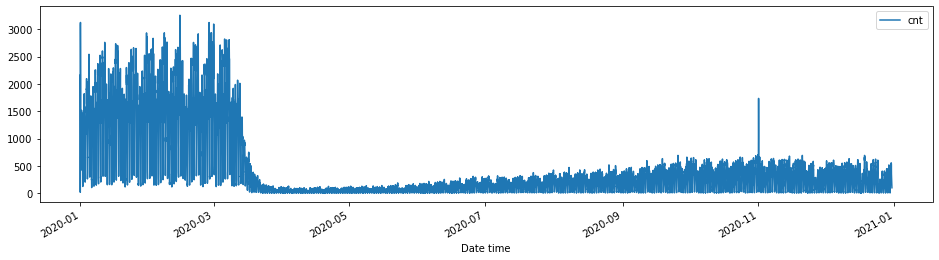

In [14]:
df[df['Date time'].isin(df['Date time'].unique()[:])].plot(x='Date time', y='cnt', figsize=(16, 4))

In [15]:
df.columns

Index(['Date time', 'Maximum Temperature', 'Minimum Temperature',
       'Temperature', 'Precipitation', 'Snow', 'Wind Speed', 'Visibility',
       'Cloud Cover', 'Relative Humidity', 'Conditions_Clear',
       'Conditions_Overcast', 'Conditions_Partially cloudy', 'Conditions_Rain',
       'Conditions_Rain, Overcast', 'Conditions_Rain, Partially cloudy',
       'Conditions_Snow', 'Conditions_Snow, Overcast',
       'Conditions_Snow, Partially cloudy', 'cnt', 'start_hour_0',
       'start_hour_1', 'start_hour_2', 'start_hour_3', 'start_hour_4',
       'start_hour_5', 'start_hour_6', 'start_hour_7', 'start_hour_8',
       'start_hour_9', 'start_hour_10', 'start_hour_11', 'start_hour_12',
       'start_hour_13', 'start_hour_14', 'start_hour_15', 'start_hour_16',
       'start_hour_17', 'start_hour_18', 'start_hour_19', 'start_hour_20',
       'start_hour_21', 'start_hour_22', 'start_hour_23', 'start_month_1',
       'start_month_2', 'start_month_3', 'start_month_4', 'start_month_5',
     

In [16]:
# scaling
continuous_fields = ['Maximum Temperature', 'Minimum Temperature',
       'Temperature', 'Precipitation', 'Snow', 'Wind Speed', 'Visibility',
       'Cloud Cover', 'Relative Humidity', 'cnt']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for field in continuous_fields:
    mean, std = df[field].mean(), df[field].std()
    scaled_features[field] = [mean, std]
    df.loc[:, field] = (df[field] - mean)/std
scaled_features

{'Maximum Temperature': [14.579827566518214, 8.85808797068467],
 'Minimum Temperature': [14.579827566518214, 8.85808797068467],
 'Temperature': [14.579827566518214, 8.85808797068467],
 'Precipitation': [0.07291195614936623, 0.6224606721019549],
 'Snow': [0.03240264930912413, 0.5528196798098203],
 'Wind Speed': [10.981980130181569, 6.917772351861037],
 'Visibility': [15.293919150393972, 2.4242854536075398],
 'Cloud Cover': [22.510671462829738, 23.26352750950378],
 'Relative Humidity': [65.3257879410757, 18.188791012027448],
 'cnt': [420.34589471280117, 582.4072559309061]}

In [17]:
# Create a backup of df before we drop these fields - we'll need this later to plot our testing data
df_backup = df.copy()

fields_to_drop = ['Date time']
df.drop(fields_to_drop, axis=1, inplace = True)
df.head()

,Maximum Temperature,Minimum Temperature,Temperature,Precipitation,Snow,Wind Speed,Visibility,Cloud Cover,Relative Humidity,Conditions_Clear,Conditions_Overcast,Conditions_Partially cloudy,Conditions_Rain,"Conditions_Rain, Overcast","Conditions_Rain, Partially cloudy",Conditions_Snow,"Conditions_Snow, Overcast","Conditions_Snow, Partially cloudy",cnt,start_hour_0,start_hour_1,start_hour_2,start_hour_3,start_hour_4,start_hour_5,start_hour_6,start_hour_7,start_hour_8,start_hour_9,start_hour_10,start_hour_11,start_hour_12,start_hour_13,start_hour_14,start_hour_15,start_hour_16,start_hour_17,start_hour_18,start_hour_19,start_hour_20,start_hour_21,start_hour_22,start_hour_23,start_month_1,start_month_2,start_month_3,start_month_4,start_month_5,start_month_6,start_month_7,start_month_8,start_month_9,start_month_10,start_month_11,start_month_12,start_day_1,start_day_2,start_day_3,start_day_4,start_day_5,start_day_6,start_day_7,start_day_8,start_day_9,start_day_10,start_day_11,start_day_12,start_day_13,start_day_14,start_day_15,start_day_16,start_day_17,start_day_18,start_day_19,start_day_20,start_day_21,start_day_22,start_day_23,start_day_24,start_day_25,start_day_26,start_day_27,start_day_28,start_day_29,start_day_30,start_day_31,weekend_0,weekend_1,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7
0,-1.081478,-1.081478,-1.081478,-0.117135,-0.058613,1.607168,0.291253,1.276218,0.060708,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.992157,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
1,-1.081478,-1.081478,-1.081478,-0.117135,-0.058613,1.607168,0.291253,1.276218,0.060708,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.687399,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0
2,-1.149213,-1.149213,-1.149213,-0.117135,-0.058613,1.057858,0.291253,-0.271269,-0.038254,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.147706,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
3,-1.149213,-1.149213,-1.149213,-0.117135,-0.058613,1.057858,0.291253,-0.271269,-0.038254,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.563223,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
4,-1.160502,-1.160502,-1.160502,-0.117135,-0.058613,1.057858,0.291253,1.005408,0.097544,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.642205,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0


In [18]:
# Split of 60 days of data from the end of the df for validation
validation_length = -15*24
validation_data = df[validation_length:]
df = df[:validation_length]

# Split of 21 days of data from the end of the df for testing
test_length = -42*24
test_data = df[test_length:]
df = df[:test_length]

# The remaining (earlier) data will be used for training
train_data = df

# What have we ended up with?
print(f'''Validation data length: {len(validation_data)}
Test data length: {len(test_data)}
Train data length: {len(train_data)}''')

Validation data length: 360
Test data length: 1008
Train data length: 16146


In [19]:
# Separate the data into feature and target fields
target_fields = ['cnt']

train_features, train_targets = train_data.drop(target_fields, axis=1), train_data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]
validation_features, validation_targets = validation_data.drop(target_fields, axis=1), validation_data[target_fields]

In [20]:
train_features.shape[1]

94

In [15]:
l_rate = 0.03
mse_loss = nn.MSELoss(reduction = 'mean')

In [16]:
train_features

,Maximum Temperature,Minimum Temperature,Temperature,Precipitation,Snow,Wind Speed,Visibility,Cloud Cover,Relative Humidity,Conditions_Clear,Conditions_Overcast,Conditions_Partially cloudy,Conditions_Rain,"Conditions_Rain, Overcast","Conditions_Rain, Partially cloudy",Conditions_Snow,"Conditions_Snow, Overcast","Conditions_Snow, Partially cloudy",start_hour_0,start_hour_1,start_hour_2,start_hour_3,start_hour_4,start_hour_5,start_hour_6,start_hour_7,start_hour_8,start_hour_9,start_hour_10,start_hour_11,start_hour_12,start_hour_13,start_hour_14,start_hour_15,start_hour_16,start_hour_17,start_hour_18,start_hour_19,start_hour_20,start_hour_21,start_hour_22,start_hour_23,start_month_1,start_month_2,start_month_3,start_month_4,start_month_5,start_month_6,start_month_7,start_month_8,start_month_9,start_month_10,start_month_11,start_month_12,start_day_1,start_day_2,start_day_3,start_day_4,start_day_5,start_day_6,start_day_7,start_day_8,start_day_9,start_day_10,start_day_11,start_day_12,start_day_13,start_day_14,start_day_15,start_day_16,start_day_17,start_day_18,start_day_19,start_day_20,start_day_21,start_day_22,start_day_23,start_day_24,start_day_25,start_day_26,start_day_27,start_day_28,start_day_29,start_day_30,start_day_31,weekend_0,weekend_1,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7
0,-1.081478,-1.081478,-1.081478,-0.117135,-0.058613,1.607168,0.291253,1.276218,0.060708,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
1,-1.081478,-1.081478,-1.081478,-0.117135,-0.058613,1.607168,0.291253,1.276218,0.060708,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0
2,-1.149213,-1.149213,-1.149213,-0.117135,-0.058613,1.057858,0.291253,-0.271269,-0.038254,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
3,-1.149213,-1.149213,-1.149213,-0.117135,-0.058613,1.057858,0.291253,-0.271269,-0.038254,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
4,-1.160502,-1.160502,-1.160502,-0.117135,-0.058613,1.057858,0.291253,1.005408,0.097544,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16141,-1.081478,-1.081478,-1.081478,-0.117135,-0.058613,2.344399,0.291253,1.259024,0.409275,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
16142,-1.081478,-1.081478,-1.081478,-0.117135,-0.058613,2.344399,0.291253,1.259024,0.409275,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
16143,-0.957298,-0.957298,-0.957298,-0.117135,-0.058613,2.633510,0.291253,1.271919,0.110189,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
16144,-0.957298,-0.957298,-0.957298,-0.117135,-0.058613,2.633510,0

# PyTorch Approach - doesn't work -> Tensors are empty

In [19]:
#Backup
class Regression(pl.LightningModule):
    
### The Model ### 

    # Question: what will your model architecture look like?
    # Initialize the layers
    # Here we have one input layer (size 56 as we have 56 features), one hidden layer (size 10), 
    # and one output layer (size 1 as we are predicting a single value)
    def __init__(self):
        super(Regression, self).__init__()
        self.fc1 = nn.Linear(train_features.shape[1], 20)
        self.fc2 = nn.Linear(20, 1)
        
    
    # Question: how should the forward pass be performed, and what will its ouputs be?
    # Perform the forward pass
    # We're using the sigmoid activation function on our hidden layer, but our output layer has no activation 
    # function as we're predicting a continuous variable so we want the actual number predicted
    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = self.fc2(x)
        return x
    
    
### The Data Loaders ###     
    
    # Question: How do you want to load your data into the model?
    # Define functions for data loading: train / validate / test
    def train_dataloader(self):
        train_dataset = TensorDataset(torch.tensor(train_features.values).float(), torch.tensor(train_targets[['cnt']].values).float())
        train_loader = DataLoader(dataset = train_dataset, batch_size = 64, num_workers=8)
        return train_loader
        
    def val_dataloader(self):
        validation_dataset = TensorDataset(torch.tensor(validation_features.values).float(), torch.tensor(validation_targets[['cnt']].values).float())
        validation_loader = DataLoader(dataset = validation_dataset, batch_size = 64, num_workers=8)
        return validation_loader
    
    def test_dataloader(self):
        test_dataset = TensorDataset(torch.tensor(test_features.values).float(), torch.tensor(test_targets[['cnt']].values).float())
        test_loader = DataLoader(dataset = test_dataset, batch_size = 64, num_workers=8)
        return test_loader

### The Optimizer ### 

    # Question: what optimizer will I use?
    # Define optimizer function: here we are using Stochastic Gradient Descent
    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=l_rate)
        return optimizer

### Training ### 

    # Question: what should a training step look like?
    # Define training step
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = mse_loss(logits, y)
        self.log('train_loss', loss)
        # Add logging
        logs = {'loss': loss}
        return {'loss': loss, 'log': logs}
        

### Validation ### 
    
    # Question: what should a validation step look like?
    # Define validation step
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = mse_loss(logits, y)
        return {'val_loss': loss}

    # Define validation epoch end
    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        tensorboard_logs = {'val_loss': avg_loss}
        return {'avg_val_loss': avg_loss, 'log': tensorboard_logs}

### Testing ###     

    # Question: what should a test step look like?
    # Define test step
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = mse_loss(logits, y)
        correct = torch.sum(logits == y.data)
        
        # I want to visualize my predictions vs my actuals so here I'm going to 
        # add these lines to extract the data for plotting later on
        predictions_pred.append(logits)
        predictions_actual.append(y.data)
        return {'test_loss': loss, 'test_correct': correct, 'logits': logits}
    
    # Define test end
    def test_epoch_end(self, outputs):
        avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
        logs = {'test_loss': avg_loss}      
        return {'avg_test_loss': avg_loss, 'log': logs, 'progress_bar': logs }

In [55]:
import torch
from torch import nn
import pytorch_lightning as pl
from torch.utils.data import DataLoader, random_split
from torch.nn import functional as F
from torchvision.datasets import MNIST
from torchvision import datasets, transforms
import os
pl.overrides.data_parallel.LightningDataParallel

class LightningTaxiRegressor(pl.LightningModule):

    def __init__(self):
        #     super().__init__()

        #     # mnist images are (1, 28, 28) (channels, width, height) 
        #     self.layer_1 = torch.nn.Linear(train_features.shape[1], 20)
        #     self.layer_2 = torch.nn.Linear(20, 1)
    
        super().__init__()
        self.fc1 = nn.Linear(train_features.shape[1], 20)
        self.fc2 = nn.Linear(20, 1)

    def forward(self, x):
        # #      batch_size, channels, width, height = x.size()

        #       # (b, 1, 28, 28) -> (b, 1*28*28)
        #       x = x.view(train_features.shape[1], 1)

        #       # layer 1 (b, 1*28*28) -> (b, 128)
        #       x = self.layer_1(x)
        #       x = torch.relu(x)

        #       # layer 3 (b, 256) -> (b, 10)
        #       x = self.layer_2(x)
        x = torch.sigmoid(self.fc1(x))
        x = self.fc2(x)

 
        # probability distribution over labels
        #   x = torch.log_softmax(x, dim=1)
        return x
        #val steps,etc: loss = mse_loss(logits, y)

    def mse_loss(self, logits, labels):
        mse_loss = nn.MSELoss(reduction = 'mean')
        return mse_loss
        #return F.nll_loss(logits, labels)
    

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = F.mse_loss(logits, y)
        #loss = self.cross_entropy_loss(logits, y)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss


    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = F.mse_loss(logits, y)
        #loss = self.cross_entropy_loss(logits, y)
        #self.log('val_loss', loss)
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        #return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=3e-2)
        return optimizer


class DataModule(pl.LightningDataModule):

    def setup(self, stage):
                # transforms for images
        #         transform=transforms.Compose([transforms.ToTensor(), 
        #                                       transforms.Normalize((0.1307,), (0.3081,))])
      
    # prepare transforms standard to MNIST
        self.taxi_train = TensorDataset(torch.tensor(train_features.values).float(), torch.tensor(train_targets[['cnt']].values).float())
        self.taxi_test = TensorDataset(torch.tensor(validation_features.values).float(), torch.tensor(validation_targets[['cnt']].values).float())

    def train_dataloader(self):
        return DataLoader(self.taxi_train, batch_size=16, num_workers=8)

    def val_dataloader(self):
        return DataLoader(self.taxi_test, batch_size=16, num_workers=8)

    
data_module = DataModule()


# train
model = LightningTaxiRegressor()
trainer = pl.Trainer(max_epochs = 10)


trainer.fit(model, data_module)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | fc1  | Linear | 1.9 K 
1 | fc2  | Linear | 21    
--------------------------------
1.9 K     Trainable params
0         Non-trainable params
1.9 K     Total params
0.008     Total estimated model params size (MB)


Epoch 0:  98%|██████████████████████████████████████████████████████████████▋ | 1011/1033 [00:16<00:00, 61.46it/s, loss=0.0541, v_num=77, val_loss_epoch=0.295, train_loss_step=0.0155]
Validating: 0it [00:00, ?it/s]
Epoch 1:  98%|████████████████▌| 1010/1033 [00:19<00:00, 50.58it/s, loss=0.0342, v_num=77, val_loss_epoch=0.0219, train_loss_step=0.0262, train_loss_epoch=0.203, val_loss_step=0.0148]
Validating: 0it [00:00, ?it/s]
Epoch 2:  98%|█████████████████▌| 1010/1033 [00:19<00:00, 52.83it/s, loss=0.0636, v_num=77, val_loss_epoch=0.046, train_loss_step=0.0363, train_loss_epoch=0.163, val_loss_step=0.0306]
Validating: 0it [00:00, ?it/s]
Epoch 3:  98%|██████████████████▌| 1010/1033 [00:19<00:00, 52.32it/s, loss=0.05, v_num=77, val_loss_epoch=0.0401, train_loss_step=0.0118, train_loss_epoch=0.160, val_loss_step=0.0203]
Validating: 0it [00:00, ?it/s]
Epoch 4:  98%|████████████████▌| 1010/1033 [00:17<00:00, 58.72it/s, loss=0.0362, v_num=77, val_loss_epoch=0.0433, train_loss_step=0.014, tra

In [62]:
model = LightningTaxiRegressor()
trainer = Trainer(max_epochs = 15, fast_dev_run=False)  # Option to check if it's working at all: fast_dev_run=True 
                                    # Option to implement early stopping: early_stop_callback=True
trainer.fit(model, data_module)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | fc1  | Linear | 1.9 K 
1 | fc2  | Linear | 21    
--------------------------------
1.9 K     Trainable params
0         Non-trainable params
1.9 K     Total params
0.008     Total estimated model params size (MB)


Epoch 0:  98%|█████████████████████████████████████████████████████████████▌ | 1010/1033 [00:20<00:00, 49.61it/s, loss=0.0384, v_num=78, val_loss_epoch=0.307, train_loss_step=0.00782]
Validating: 0it [00:00, ?it/s]
Epoch 1:  98%|███████████████▋| 1010/1033 [00:19<00:00, 51.81it/s, loss=0.0428, v_num=78, val_loss_epoch=0.0175, train_loss_step=0.0183, train_loss_epoch=0.206, val_loss_step=0.00867]
Validating: 0it [00:00, ?it/s]
Epoch 2:  98%|█████████████████▌| 1010/1033 [00:18<00:00, 53.92it/s, loss=0.0591, v_num=78, val_loss_epoch=0.0648, train_loss_step=0.025, train_loss_epoch=0.169, val_loss_step=0.0337]
Validating: 0it [00:00, ?it/s]
Epoch 3:  98%|██████████████▋| 1010/1033 [00:18<00:00, 53.40it/s, loss=0.0347, v_num=78, val_loss_epoch=0.0333, train_loss_step=0.00377, train_loss_epoch=0.151, val_loss_step=0.00605]
Validating: 0it [00:00, ?it/s]
Epoch 4:  98%|████████████████▌| 1010/1033 [00:18<00:00, 54.00it/s, loss=0.0249, v_num=78, val_loss_epoch=0.0488, train_loss_step=0.0119, tr

In [63]:
model

LightningTaxiRegressor(
  (fc1): Linear(in_features=94, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=1, bias=True)
)

In [64]:
# Here I'm creating 2 empty lists into which I'll be appending my predictions and actuals as I go
# - you don't have to do this, but if you want to examine them in detail or plot them, then it's convenient
predictions_pred = []
predictions_actual = []
trainer.test()

([], [])

In [65]:
# Here I'm getting the mean and standard deviation values for 'cnt', so I can convert my predicted
# values back to actual numbers of bike rides again, instead of the scaled values used to predict on
mean = scaled_features['cnt'][0]
std = scaled_features['cnt'][1]

In [66]:
predictions_pred

[]

In [67]:
# Get dates for plotting
datesx = list(df_backup[test_length:]['Date time'])

# Get predicted points (scaled back to their original size)
plot_pred = []
for i in range(len(predictions_pred)):
    plot_pred.extend(predictions_pred[i].T.numpy()[0] * std + mean)

# Get actual points (scaled back to their original size)
plot_actual = []
for i in range(len(predictions_actual)):
    plot_actual.extend(predictions_actual[i].T.numpy()[0] * std + mean)

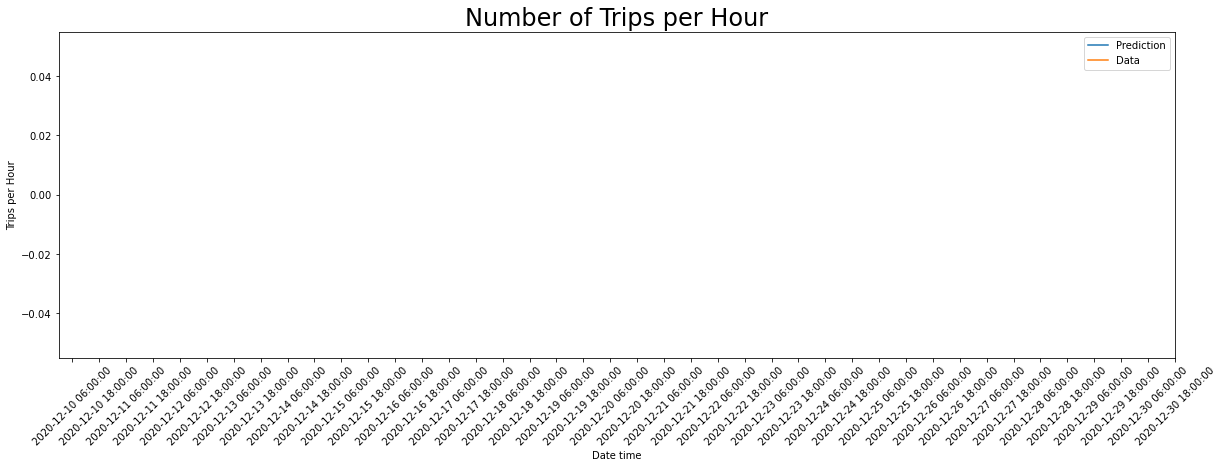

In [68]:
# And finally we can see that our network has done a decent job of estimating!
fig, ax = plt.subplots(figsize=(20,6))
ax.plot(plot_pred, label='Prediction')
ax.plot(plot_actual, label='Data')
ax.set_xticks(np.arange(len(datesx))[12::24])
ax.set_xticklabels(datesx[12::24], rotation=45)
ax.set_title('Number of Trips per Hour', size=24)
ax.set_xlabel("Date time")
ax.set_ylabel("Trips per Hour")
ax.legend()

In [61]:
# The tensorboard logger is pretty nifty too!
%load_ext tensorboard
%tensorboard --logdir lightning_logs

Reusing TensorBoard on port 6006 (pid 17368), started 2 days, 3:50:24 ago. (Use '!kill 17368' to kill it.)

# Keras Approach

In [11]:
df

,Date time,Maximum Temperature,Minimum Temperature,Temperature,Precipitation,Snow,Wind Speed,Visibility,Cloud Cover,Relative Humidity,Conditions_Clear,Conditions_Overcast,Conditions_Partially cloudy,Conditions_Rain,"Conditions_Rain, Overcast","Conditions_Rain, Partially cloudy",Conditions_Snow,"Conditions_Snow, Overcast","Conditions_Snow, Partially cloudy",cnt,start_hour_0,start_hour_1,start_hour_2,start_hour_3,start_hour_4,start_hour_5,start_hour_6,start_hour_7,start_hour_8,start_hour_9,start_hour_10,start_hour_11,start_hour_12,start_hour_13,start_hour_14,start_hour_15,start_hour_16,start_hour_17,start_hour_18,start_hour_19,start_hour_20,start_hour_21,start_hour_22,start_hour_23,start_month_1,start_month_2,start_month_3,start_month_4,start_month_5,start_month_6,start_month_7,start_month_8,start_month_9,start_month_10,start_month_11,start_month_12,start_day_1,start_day_2,start_day_3,start_day_4,start_day_5,start_day_6,start_day_7,start_day_8,start_day_9,start_day_10,start_day_11,start_day_12,start_day_13,start_day_14,start_day_15,start_day_16,start_day_17,start_day_18,start_day_19,start_day_20,start_day_21,start_day_22,start_day_23,start_day_24,start_day_25,start_day_26,start_day_27,start_day_28,start_day_29,start_day_30,start_day_31,weekend_0,weekend_1,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7
0,2020-01-01 00:00:00,5.0,5.0,5.0,0.0,0.0,22.1,16.0,52.2,66.43,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2163,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
1,2020-01-01 01:00:00,4.4,4.4,4.4,0.0,0.0,18.3,16.0,16.2,64.63,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2836,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
2,2020-01-01 01:00:00,4.4,4.4,4.4,0.0,0.0,18.3,16.0,16.2,64.63,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3078,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
3,2020-01-01 02:00:00,4.3,4.3,4.3,0.0,0.0,18.3,16.0,45.9,67.10,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3124,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
4,2020-01-01 02:00:00,4.3,4.3,4.3,0.0,0.0,18.3,16.0,45.9,67.10,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3105,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17508,2020-12-30 22:00:00,5.0,5.0,5.0,0.0,0.0,12.9,16.0,1.3,63.99,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,220,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0
17509,2020-12-30 22:00:00,5.0,5.0,5.0,0.0,0.0,12.9,16.0,1.3,63.99,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,224,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0
17510,2020-12-30 23:00:00,5.0,5.0,5.0,0.0,0.0,13.0,16.0,51.7,66.40,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,134,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0
17511,2020-12-30 23:00:00,5.0,5.0,5.0,0.0,0.0,13.0,16.0,51.7,66.40,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,132,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [12]:
X = df.drop(["cnt", "Date time"], axis=1)
y = df["cnt"]

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [14]:
print(X_train.shape)
print(y_train.shape)

(14010, 94)
(14010,)


In [15]:
X_train

,Maximum Temperature,Minimum Temperature,Temperature,Precipitation,Snow,Wind Speed,Visibility,Cloud Cover,Relative Humidity,Conditions_Clear,Conditions_Overcast,Conditions_Partially cloudy,Conditions_Rain,"Conditions_Rain, Overcast","Conditions_Rain, Partially cloudy",Conditions_Snow,"Conditions_Snow, Overcast","Conditions_Snow, Partially cloudy",start_hour_0,start_hour_1,start_hour_2,start_hour_3,start_hour_4,start_hour_5,start_hour_6,start_hour_7,start_hour_8,start_hour_9,start_hour_10,start_hour_11,start_hour_12,start_hour_13,start_hour_14,start_hour_15,start_hour_16,start_hour_17,start_hour_18,start_hour_19,start_hour_20,start_hour_21,start_hour_22,start_hour_23,start_month_1,start_month_2,start_month_3,start_month_4,start_month_5,start_month_6,start_month_7,start_month_8,start_month_9,start_month_10,start_month_11,start_month_12,start_day_1,start_day_2,start_day_3,start_day_4,start_day_5,start_day_6,start_day_7,start_day_8,start_day_9,start_day_10,start_day_11,start_day_12,start_day_13,start_day_14,start_day_15,start_day_16,start_day_17,start_day_18,start_day_19,start_day_20,start_day_21,start_day_22,start_day_23,start_day_24,start_day_25,start_day_26,start_day_27,start_day_28,start_day_29,start_day_30,start_day_31,weekend_0,weekend_1,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7
14223,18.4,18.4,18.4,0.0,0.0,5.3,15.9,52.1,89.84,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
2239,7.8,7.8,7.8,0.0,0.0,5.5,16.0,2.6,43.44,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
13882,17.2,17.2,17.2,0.0,0.0,13.0,16.0,52.3,72.12,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
10059,31.7,31.7,31.7,0.0,0.0,16.5,16.0,44.6,57.09,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0
14190,18.9,18.9,18.9,0.0,0.0,5.2,11.1,52.3,89.87,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2333,8.3,8.3,8.3,0.0,0.0,11.2,14.0,52.3,79.48,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
17415,6.7,6.7,6.7,0.0,0.0,20.4,16.0,0.4,58.98,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0
10013,34.3,34.3,34.3,0.0,0.0,16.6,16.0,0.8,44.69,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0
545,16.8,16.8,16.8,0.0,0.0,36.6,16.0,51.2,64.19,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1


In [16]:
#old
from keras import models
from keras import layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    # MSE = Mean Squared Error
    # MAE = Mean Absolut Error
    # RMSPROP adaptive learning method based on Stochastic Gradient Descent
    # If you use SGD, your network might not converge....
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [17]:
def NNRegressor(nn_optimizer="adam"):
    model = keras.Sequential(
    [layers.Dense(36, activation="relu", input_shape=[X_train.shape[1]]),
     layers.Dropout(0.2),
     layers.Dense(36, activation="relu"),
     layers.Dropout(0.2),
     layers.Dense(24, activation="relu"),
     layers.Dropout(0.2),
     layers.Dense(1)])
    
    if nn_optimizer == "adam":
        optimizer = keras.optimizers.Adam()
    elif optimizer == 'SDG':
        optimizer = keras.optimizers.SDG()
    else:
        print('Default optimizer selected: RMSProp')
        optimizer = keras.optimizers.RMSProp(0.001)
    
    model.compile(loss="mse", optimizer=optimizer, metrics=["mse", "mae"])
    
    return model

In [18]:
# Hyperparameters
epochs = 20

In [19]:
rs = RobustScaler()
nn = KerasRegressor(NNRegressor, epochs=epochs, validation_split=0.2, nn_optimizer="adam")

In [20]:
pipe = Pipeline([
    ("Robust Scaler", rs),
    ("Neural Network", nn)
])

In [21]:
pipe.fit(X_train, y_train)

Epoch 1/20
351/351 [==============================] - 2s 3ms/step - loss: 359792.7500 - mse: 359792.7500 - mae: 362.6130 - val_loss: 181526.1094 - val_mse: 181526.1094 - val_mae: 290.2007
Epoch 2/20
351/351 [==============================] - 1s 2ms/step - loss: 142579.3125 - mse: 142579.3125 - mae: 239.9754 - val_loss: 89300.8750 - val_mse: 89300.8750 - val_mae: 175.3190
Epoch 3/20
351/351 [==============================] - 1s 2ms/step - loss: 92169.6875 - mse: 92169.6875 - mae: 176.6920 - val_loss: 72725.0859 - val_mse: 72725.0859 - val_mae: 148.7414
Epoch 4/20
351/351 [==============================] - 1s 2ms/step - loss: 82618.1250 - mse: 82618.1250 - mae: 163.6728 - val_loss: 67024.7422 - val_mse: 67024.7422 - val_mae: 140.5069
Epoch 5/20
351/351 [==============================] - 1s 2ms/step - loss: 79564.1875 - mse: 79564.1875 - mae: 157.0955 - val_loss: 65975.2266 - val_mse: 65975.2266 - val_mae: 136.3575
Epoch 6/20
351/351 [==============================] - 1s 2ms/step - loss: 

Pipeline(steps=[('Robust Scaler', RobustScaler()),
                ('Neural Network',
                 <tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x00000227D7395700>)])

In [24]:
print("RMSE: ", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print("MAE: ", metrics.mean_absolute_error(y_test, y_pred))

NameError: name 'y_pred' is not defined

In [ ]:
model_pds = keras.Sequential(
    [layers.Dense(36, activation="relu", input_shape=[X_train_scaled.shape[1]]),
     layers.Dense(36, activation="relu"),
     layers.Dense(1)])

optimizer = keras.optimizers.RMSprop(0.001)

model_pds.compile(loss='mse', optimizer=optimizer, metrics=["mae", "mse"])

# whole in one

Reading in the data
Add weather data
Sort values
Earliest date - 2020-01-01 00:00:00 
Latest date - 2021-05-20 03:00:00
Total number of days - 732.2083333333334


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type   | Params
--------------------------------
0 | fc1  | Linear | 1.9 K 
1 | fc2  | Linear | 21    
--------------------------------
1.9 K     Trainable params
0         Non-trainable params
1.9 K     Total params
0.008     Total estimated model params size (MB)


Validation data length: 360
Test data length: 1008
Train data length: 16205
Epoch 0:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 254/260 [00:05<00:00, 46.91it/s, loss=0.0731, v_num=103]
Validating: 0it [00:00, ?it/s]
Epoch 1:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 254/260 [00:04<00:00, 54.57it/s, loss=0.0508, v_num=103]
Validating: 0it [00:00, ?it/s]
Epoch 2:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 254/260 [00:04<00:00, 62.92it/s, loss=0.0403, v_num=103]
Validating: 0it [00:00, ?it/s]
Epoch 3:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 254/260 [00:04<00:00, 62.80it/s, loss=0.0359, v_num=103]
Validating: 0it [00:00, ?it/s]
Epoch 4:  98%|██████████████████████████████████████████████████

Epoch 12:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 254/260 [00:04<00:00, 62.44it/s, loss=0.0282, v_num=103]
Validating: 0it [00:00, ?it/s]
Epoch 13:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 254/260 [00:04<00:00, 57.35it/s, loss=0.0269, v_num=103]
Validating: 0it [00:00, ?it/s]
Epoch 14:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 254/260 [00:04<00:00, 57.76it/s, loss=0.0265, v_num=103]
Validating: 0it [00:00, ?it/s]
Testing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.57it/s]
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{}
-------------------------------------------------------------

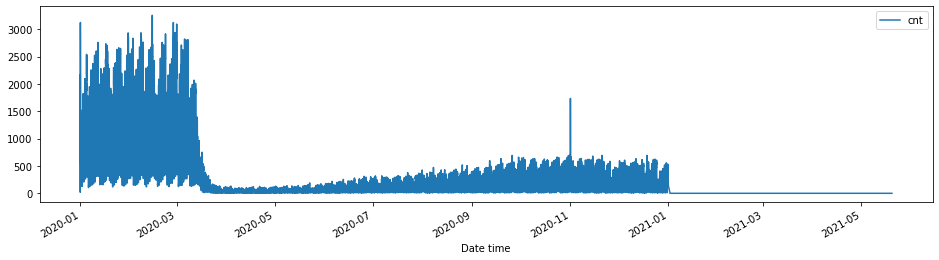

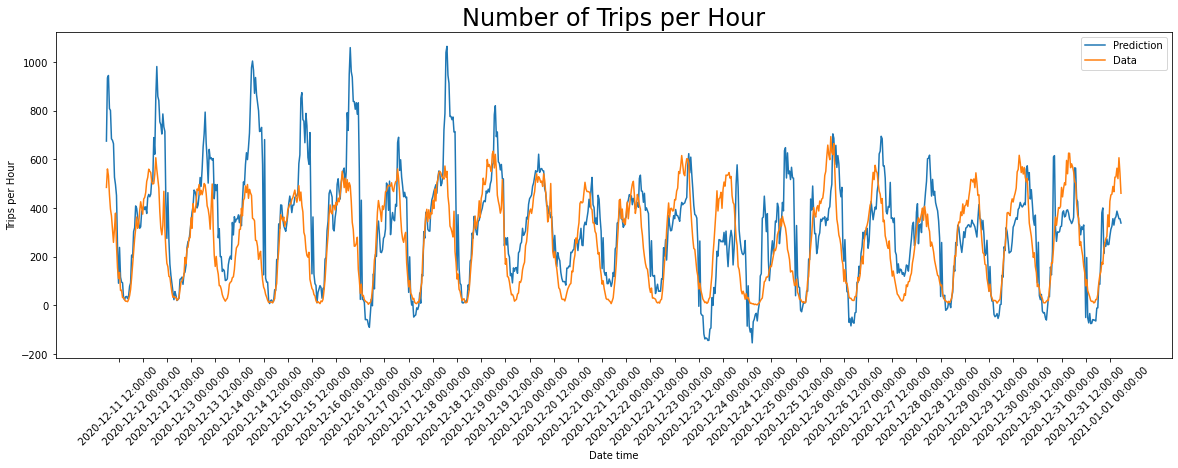

In [11]:
# Let's import some basic libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

import yellowcab
from datetime import datetime

# From here on out we start preparing the data for PyTorch - let's first get the libraries we'll need
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader
import pytorch_lightning as pl


pd.set_option('display.max_columns', None)


# And then import and view the data
print('Reading in the data')
df_orig = yellowcab.io.read_all_files('parquet')
print('Add weather data')
df_orig = yellowcab.io.utils.add_weather_data(df_orig)
#df_orig = df_orig[df_orig['tpep_pickup_datetime'] < datetime(2020, 12, 31)]
print('Sort values')
df_orig.sort_values('tpep_pickup_datetime')


df_edit = df_orig[['Date time', 'start_month', 'start_day', 'start_hour', 
             'weekend', 'weekday', 'Maximum Temperature', 
             'Minimum Temperature', 'Temperature',
             'Precipitation', 'Snow', 'Wind Speed', 'Visibility',
             'Cloud Cover', 'Relative Humidity', 'Conditions',
             'trip_distance']]

df_edit = df_edit.dropna(axis=0)


onehot_fields = ['Conditions']
for field in onehot_fields:
    dummies = pd.get_dummies(df_edit[field], prefix=field, drop_first=False)
    df_edit_1 = pd.concat([df_edit, dummies], axis=1)
df_edit_1 = df_edit_1.drop(onehot_fields, axis = 1)
df_edit_1.head()


df = df_edit_1.groupby(['Date time', 'start_hour']).median().reset_index()
df['cnt'] = df_edit_1.groupby(['Date time', 'start_hour']).count().reset_index()['trip_distance']
df.drop(columns='trip_distance', inplace=True)
df.sample(5)


# onehot encoding
onehot_fields = ['start_hour', 'start_month', 'start_day', 'weekend',
                'weekday']
for field in onehot_fields:
    dummies = pd.get_dummies(df[field], prefix=field, drop_first=False)
    df = pd.concat([df, dummies], axis=1)
df = df.drop(onehot_fields, axis = 1)
df.head()


# Being a timeseries problem, let's look at the date ranges we have available
print(f"""Earliest date - {df['Date time'].min()} 
Latest date - {df['Date time'].max()}
Total number of days - {len(df) / 24}""")


df[df['Date time'].isin(df['Date time'].unique()[:])].plot(x='Date time', y='cnt', figsize=(16, 4))


# scaling
continuous_fields = ['Maximum Temperature', 'Minimum Temperature',
       'Temperature', 'Precipitation', 'Snow', 'Wind Speed', 'Visibility',
       'Cloud Cover', 'Relative Humidity', 'cnt']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for field in continuous_fields:
    mean, std = df[field].mean(), df[field].std()
    scaled_features[field] = [mean, std]
    df.loc[:, field] = (df[field] - mean)/std
scaled_features


# Create a backup of df before we drop these fields - we'll need this later to plot our testing data
df_backup = df.copy()

fields_to_drop = ['Date time']
df.drop(fields_to_drop, axis=1, inplace = True)
df.head()


# Split of 60 days of data from the end of the df for validation
validation_length = -15*24
validation_data = df[validation_length:]
df = df[:validation_length]

# Split of 21 days of data from the end of the df for testing
test_length = -42*24
test_data = df[test_length:]
df = df[:test_length]

# The remaining (earlier) data will be used for training
train_data = df

# What have we ended up with?
print(f'''Validation data length: {len(validation_data)}
Test data length: {len(test_data)}
Train data length: {len(train_data)}''')


# Separate the data into feature and target fields
target_fields = ['cnt']

train_features, train_targets = train_data.drop(target_fields, axis=1), train_data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]
validation_features, validation_targets = validation_data.drop(target_fields, axis=1), validation_data[target_fields]


l_rate = 0.03
mse_loss = nn.MSELoss(reduction = 'mean')


class Regression(pl.LightningModule):
    
### The Model ### 

    # Question: what will your model architecture look like?
    # Initialize the layers
    # Here we have one input layer (size 56 as we have 56 features), one hidden layer (size 10), 
    # and one output layer (size 1 as we are predicting a single value)
    def __init__(self):
        super(Regression, self).__init__()
        self.fc1 = nn.Linear(train_features.shape[1], 20)
        self.fc2 = nn.Linear(20, 1)
    
    # Question: how should the forward pass be performed, and what will its ouputs be?
    # Perform the forward pass
    # We're using the sigmoid activation function on our hidden layer, but our output layer has no activation 
    # function as we're predicting a continuous variable so we want the actual number predicted
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### The Data Loaders ###     
    
    # Question: How do you want to load your data into the model?
    # Define functions for data loading: train / validate / test
    def train_dataloader(self):
        train_dataset = TensorDataset(torch.tensor(train_features.values).float(), torch.tensor(train_targets[['cnt']].values).float())
        train_loader = DataLoader(dataset = train_dataset, batch_size = 64, num_workers=8)
        return train_loader
        
    def val_dataloader(self):
        validation_dataset = TensorDataset(torch.tensor(validation_features.values).float(), torch.tensor(validation_targets[['cnt']].values).float())
        validation_loader = DataLoader(dataset = validation_dataset, batch_size = 64, num_workers=8)
        return validation_loader
    
    def test_dataloader(self):
        test_dataset = TensorDataset(torch.tensor(test_features.values).float(), torch.tensor(test_targets[['cnt']].values).float())
        test_loader = DataLoader(dataset = test_dataset, batch_size = 64, num_workers=8)
        return test_loader

### The Optimizer ### 

    # Question: what optimizer will I use?
    # Define optimizer function: here we are using Stochastic Gradient Descent
    def configure_optimizers(self):
        return optim.SGD(self.parameters(), lr=l_rate)

### Training ### 

    # Question: what should a training step look like?
    # Define training step
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = mse_loss(logits, y)
        # Add logging
        logs = {'loss': loss}
        return {'loss': loss, 'log': logs}

### Validation ### 
    
    # Question: what should a validation step look like?
    # Define validation step
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = mse_loss(logits, y)
        return {'val_loss': loss}

    # Define validation epoch end
    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
#        tensorboard_logs = {'val_loss': avg_loss}
        #return {'avg_val_loss': avg_loss, 'log': tensorboard_logs}
        return {'avg_val_loss': avg_loss}

### Testing ###     

    # Question: what should a test step look like?
    # Define test step
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = mse_loss(logits, y)
        correct = torch.sum(logits == y.data)
        
        # I want to visualize my predictions vs my actuals so here I'm going to 
        # add these lines to extract the data for plotting later on
        predictions_pred.append(logits)
        predictions_actual.append(y.data)
        return {'test_loss': loss, 'test_correct': correct, 'logits': logits}
    
    # Define test end
    def test_epoch_end(self, outputs):
        avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
        logs = {'test_loss': avg_loss}      
        return {'avg_test_loss': avg_loss, 'log': logs, 'progress_bar': logs }
    
    
model = Regression()
trainer = Trainer(max_epochs = 15, fast_dev_run=False)  # Option to check if it's working at all: fast_dev_run=True 
                                    # Option to implement early stopping: early_stop_callback=True
trainer.fit(model)


# Here I'm creating 2 empty lists into which I'll be appending my predictions and actuals as I go
# - you don't have to do this, but if you want to examine them in detail or plot them, then it's convenient
predictions_pred = []
predictions_actual = []
trainer.test()


# Here I'm getting the mean and standard deviation values for 'cnt', so I can convert my predicted
# values back to actual numbers of bike rides again, instead of the scaled values used to predict on
mean = scaled_features['cnt'][0]
std = scaled_features['cnt'][1]


# Get dates for plotting
datesx = list(df_backup[test_length:]['Date time'])

# Get predicted points (scaled back to their original size)
plot_pred = []
for i in range(len(predictions_pred)):
    plot_pred.extend(predictions_pred[i].T.numpy()[0] * std + mean)

# Get actual points (scaled back to their original size)
plot_actual = []
for i in range(len(predictions_actual)):
    plot_actual.extend(predictions_actual[i].T.numpy()[0] * std + mean)
    
    
# And finally we can see that our network has done a decent job of estimating!
fig, ax = plt.subplots(figsize=(20,6))
ax.plot(plot_pred, label='Prediction')
ax.plot(plot_actual, label='Data')
ax.set_xticks(np.arange(len(datesx))[12::24])
ax.set_xticklabels(datesx[12::24], rotation=45)
ax.set_title('Number of Trips per Hour', size=24)
ax.set_xlabel("Date time")
ax.set_ylabel("Trips per Hour")
ax.legend()

In [4]:
def trip_count_nn(epochs=15, l_rate=0.03, vis=True):

    mse_loss = nn.MSELoss(reduction = 'mean')


    class Regression(pl.LightningModule):

    ### The Model ### 

        # Question: what will your model architecture look like?
        # Initialize the layers
        # Here we have one input layer (size 56 as we have 56 features), one hidden layer (size 10), 
        # and one output layer (size 1 as we are predicting a single value)
        def __init__(self):
            super(Regression, self).__init__()
            self.fc1 = nn.Linear(train_features.shape[1], 20)
            self.fc2 = nn.Linear(20, 1)

        # Question: how should the forward pass be performed, and what will its ouputs be?
        # Perform the forward pass
        # We're using the sigmoid activation function on our hidden layer, but our output layer has no activation 
        # function as we're predicting a continuous variable so we want the actual number predicted
        def forward(self, x):
            x = torch.sigmoid(self.fc1(x))
            x = self.fc2(x)
            return x

    ### The Data Loaders ###     

        # Question: How do you want to load your data into the model?
        # Define functions for data loading: train / validate / test
        def train_dataloader(self):
            train_dataset = TensorDataset(torch.tensor(train_features.values).float(), torch.tensor(train_targets[['cnt']].values).float())
            train_loader = DataLoader(dataset = train_dataset, batch_size = 64, num_workers=8)
            return train_loader

        def val_dataloader(self):
            validation_dataset = TensorDataset(torch.tensor(validation_features.values).float(), torch.tensor(validation_targets[['cnt']].values).float())
            validation_loader = DataLoader(dataset = validation_dataset, batch_size = 64, num_workers=8)
            return validation_loader

        def test_dataloader(self):
            test_dataset = TensorDataset(torch.tensor(test_features.values).float(), torch.tensor(test_targets[['cnt']].values).float())
            test_loader = DataLoader(dataset = test_dataset, batch_size = 64, num_workers=8)
            return test_loader

    ### The Optimizer ### 

        # Question: what optimizer will I use?
        # Define optimizer function: here we are using Stochastic Gradient Descent
        def configure_optimizers(self):
            return optim.SGD(self.parameters(), lr=l_rate)

    ### Training ### 

        # Question: what should a training step look like?
        # Define training step
        def training_step(self, batch, batch_idx):
            x, y = batch
            logits = self.forward(x)
            loss = mse_loss(logits, y)
            # Add logging
            logs = {'loss': loss}
            return {'loss': loss, 'log': logs}

    ### Validation ### 

        def validation_step(self, batch, batch_idx):
            x, y = batch
            logits = self.forward(x)
            loss = F.mse_loss(logits, y)
            #loss = self.cross_entropy_loss(logits, y)
            #self.log('val_loss', loss)
            self.log('val_loss', loss, prog_bar=True, logger=True)
            #return loss

            

        # Define validation epoch end
        def validation_epoch_end(self, outputs):
            avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
            tensorboard_logs = {'val_loss': avg_loss}
            return {'avg_val_loss': avg_loss, 'log': tensorboard_logs}

    ### Testing ###     

        # Question: what should a test step look like?
        # Define test step
        def test_step(self, batch, batch_idx):
            x, y = batch
            logits = self.forward(x)
            loss = mse_loss(logits, y)
            correct = torch.sum(logits == y.data)

            # I want to visualize my predictions vs my actuals so here I'm going to 
            # add these lines to extract the data for plotting later on
            predictions_pred.append(logits)
            predictions_actual.append(y.data)
            return {'test_loss': loss, 'test_correct': correct, 'logits': logits}

        # Define test end
        def test_epoch_end(self, outputs):
            avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
            logs = {'test_loss': avg_loss}      
            return {'avg_test_loss': avg_loss, 'log': logs, 'progress_bar': logs }


    model = Regression()
    trainer = Trainer(max_epochs = 15, fast_dev_run=False)  # Option to check if it's working at all: fast_dev_run=True 
                                        # Option to implement early stopping: early_stop_callback=True
    trainer.fit(model)


    # Here I'm creating 2 empty lists into which I'll be appending my predictions and actuals as I go
    # - you don't have to do this, but if you want to examine them in detail or plot them, then it's convenient
    predictions_pred = []
    predictions_actual = []
    trainer.test()


    # Here I'm getting the mean and standard deviation values for 'cnt', so I can convert my predicted
    # values back to actual numbers of bike rides again, instead of the scaled values used to predict on
    mean = scaled_features['cnt'][0]
    std = scaled_features['cnt'][1]


    # Get dates for plotting
    datesx = list(df_backup[test_length:]['Date time'])

    # Get predicted points (scaled back to their original size)
    plot_pred = []
    for i in range(len(predictions_pred)):
        plot_pred.extend(predictions_pred[i].T.numpy()[0] * std + mean)

    # Get actual points (scaled back to their original size)
    plot_actual = []
    for i in range(len(predictions_actual)):
        plot_actual.extend(predictions_actual[i].T.numpy()[0] * std + mean)

    if vis:
        # And finally we can see that our network has done a decent job of estimating!
        fig, ax = plt.subplots(figsize=(20,6))
        ax.plot(plot_pred, label='Prediction')
        ax.plot(plot_actual, label='Data')
        ax.set_xticks(np.arange(len(datesx))[12::24])
        ax.set_xticklabels(datesx[12::24], rotation=45)
        ax.set_title('Number of Trips per Hour', size=24)
        ax.set_xlabel("Date time")
        ax.set_ylabel("Trips per Hour")
        ax.legend()

In [5]:
trip_count_nn()

NameError: name 'nn' is not defined

In [27]:
model = MyLightningModule.load_from_checkpoint(PATH)

NameError: name 'MyLightningModule' is not defined

In [1]:
import yellowcab

Reading in the data
Add weather data
Sort values
Earliest date - 2020-01-01 00:00:00 
    Latest date - 2021-05-20 03:00:00
    Total number of days - 732.2083333333334


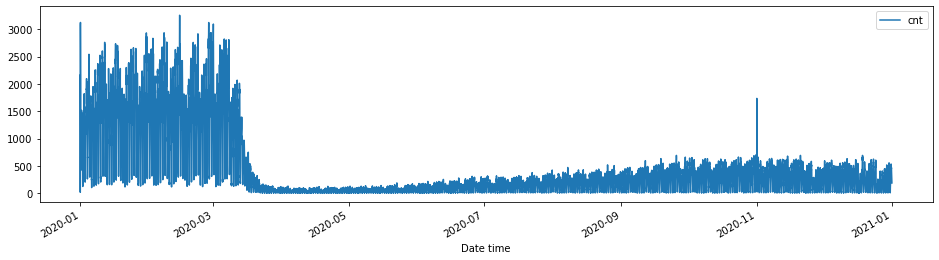

In [2]:
df, df_backup, scaled_features = yellowcab.model.full_preparing_workflow()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Validation data length: 360
    Test data length: 1008
    Train data length: 16205



  | Name | Type   | Params
--------------------------------
0 | fc1  | Linear | 1.9 K 
1 | fc2  | Linear | 21    
--------------------------------
1.9 K     Trainable params
0         Non-trainable params
1.9 K     Total params
0.008     Total estimated model params size (MB)


Validation sanity check:  50%|█████████████████████████████████████████████████████████████▌                                                             | 1/2 [00:02<00:02,  2.50s/it]
avg_val_loss tensor(0.6124)
Epoch 0:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 254/260 [00:04<00:00, 55.30it/s, loss=0.0958, v_num=174]
Validating: 0it [00:00, ?it/s]
Epoch 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 259/260 [00:06<00:00, 37.53it/s, loss=0.0958, v_num=174]
avg_val_loss tensor(0.0972)
Epoch 1:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 254/260 [00:04<00:00, 55.88it/s, loss=0.0869, v_num=174]
Validating: 0it [00:00, ?it/s]
Validating:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               

Validating:  33%|█████████████████████████████████████████████▎                                                                                          | 2/6 [00:02<00:03,  1.04it/s]
avg_val_loss tensor(0.0670)
Epoch 9:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 254/260 [00:04<00:00, 60.79it/s, loss=0.0371, v_num=174]
Validating: 0it [00:00, ?it/s]
Validating:  33%|█████████████████████████████████████████████▎                                                                                          | 2/6 [00:02<00:04,  1.07s/it]
avg_val_loss tensor(0.0720)
Epoch 10:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 254/260 [00:04<00:00, 52.46it/s, loss=0.0341, v_num=174]
Validating: 0it [00:00, ?it/s]
Validating:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               

Regression(
  (fc1): Linear(in_features=94, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=1, bias=True)
)

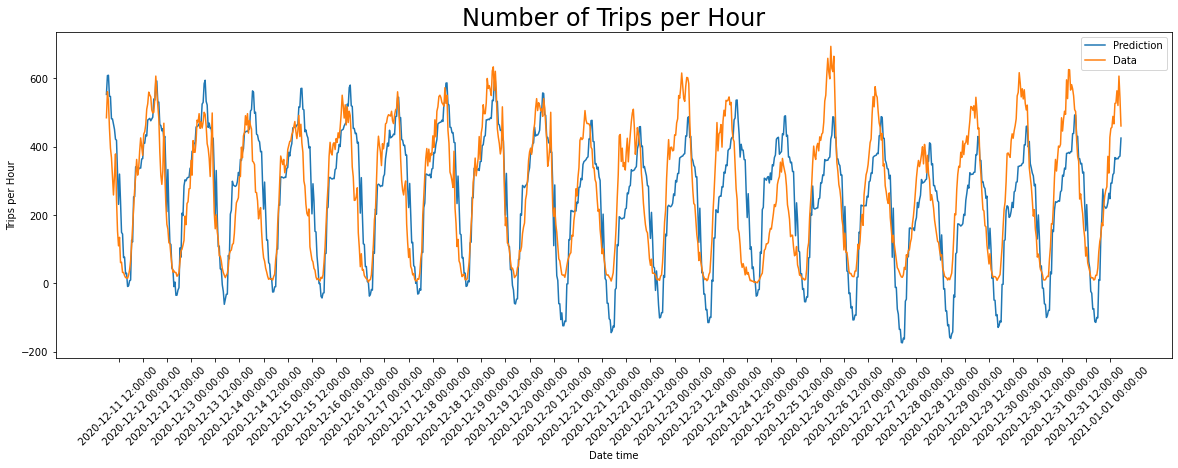

In [3]:
model = yellowcab.model.trip_count_nn(df, df_backup, scaled_features, save=True, epochs=15)
model

NameError: name 'fig' is not defined

In [21]:
import torch

In [26]:
torch.save(model.state_dict(), '/../../data/output/models/model_trip_count')

FileNotFoundError: [Errno 2] No such file or directory: '/../../data/output/models/model_trip_count'